# GaussianProcesses

## References

Exploration of using GP and Bayesian Optimisation

Useful links:

* Nando de Freitas Lecture: https://www.youtube.com/watch?v=4vGiHC35j9s [video]
* Rasmussen and Williams book: Gaussian Processes for Machine Learning [book]
* http://www.inference.org.uk/hmw26/papers/gp_intro.pdf [slide deck]

## Quick reference: 

* A Gaussian Process is a collection of random variables, any finite number of which have a joint Gaussian distribution. 

* Define a Gaussian processes as $f(x) \sim \mathcal{GP}(m(x), k(x, x')$ This is completely specified by its mean function $m(x)$ and covariance function $k(x, x')$

* Consistency means that any subset of these points is also Gaussian. For example if the GP specifies $y^{(1)}, y^{(2)} \sim \mathcal{N}(\mu, \Sigma)$ then it also specifies $y^{(1)} \sim \mathcal{N}(\mu_1, \Sigma_{11})$

* We can specify the mean $\mu$, and variance $K$, functions of the GP. This means that for any set of inputs $\mathbf{x}^{(1)}, \mathbf{x}^{(2)}$ we can compute $K(\mathbf{x}^{(1)}, \mathbf{x}^{(2)})$. This defines a join distribution over function values: $f(\mathbf{x}^{1},...f(\mathbf{x}^{(n)}) \sim \mathcal{N}(\mu, K)$. This fully specifies the GP.

### Example

* As a simple example, we can obtain a GP from the Bayesian linear regression model. We assume noisy data (additive independent identically distributed Gaussian) noise $\epsilon$ with variance $\sigma_n^2$: $\epsilon \sim \mathcal{N}(0, \sigma)$ such that $y = f(x) +\epsilon$

* Then $f(\mathbf{x}) = \mathbf{x}^{T}\mathbf{w}$, with the prior $\mathbf{w} \sim \mathcal{N}(\mathbf{0}, \Sigma_p)$. 

* The mean function is given by: $\mathbb{E}[f(\mathbf{x})] = \mathbf{x}^{T}\mathbb{E}[\mathbf{w}] = 0$

* The covariance function is given by: $\mathbb{E}[f(\mathbf{x})f(\mathbf{x'})] = \mathbf{x}^{T}\mathbb{E}[\mathbf{w}\mathbf{w}^{T}]\mathbf{x}' = \mathbf{x}^{T}\Sigma_p \mathbf{x}'$


### Implementation

`def kernel(x, x', l)`:


`def fmu(x_star, x_train, y, l)`: 

* $\mathbf{\mu} = K(X, X^*)[K(X, X) + \sigma^2\mathbf{I}]^{-1}\mathbf{y}$

`def fcovar(x_star, x_train, y, l)`:
* $\Sigma = K(X^*, X^*) - K(X, X^*)[K(X, X) + \sigma^2\mathbf{I}]^{-1}K(X^{*}, X)$


## Notation

* Notionally, the following is used:
   * x: training data - e.g. other points in the data set $\mathcal{D}$
   * x*: test data: e.g. a point that is being predicted
   
* A kernel or covariance specifies the covariance between pairs of random variables with the form:
    * $cov(f(x_p), f(x_q)) = k(x, x') = \exp(-\frac{1}{2} \mid x - x' \mid ^2)$
   

In [41]:
import numpy as np
import pdb
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
# Define a function to be explored
def f(x):
    return ((1 / (2*np.pi))*x*np.sin(x**2)-x*np.cos(np.sin(np.cos(x)))+(1-np.abs(np.sin(x)))*x) / (x+1e-6)


# Define the kernel
def kernel(x, x_dash, l=1):
    """
    The kernel or covariance between x and x_dash is defined in terms of the squared exponential covariance with
    a characteristic lengthscale l. In this case, this parameterises
    a squared exponential drop=off. 
    """
    sqdist = np.sum(x**2,1).reshape(-1,1)+np.sum(x_dash**2, 1)-2*np.dot(x, x_dash.T)
    return np.sqrt(1)*np.exp(-0.5 * sqdist / l)


def fmu(x_star, x_train, y, l=1):
    """ 
    This is the expected value of all functions f*.
    
    [This is equation 2.25, pg 17 in 'GP for ML']
    
    If len(x_star) == N_* and len(x_train) == N and len(y) == N_*
    
    """
    N_star = len(x_star)
    N_train = len(x_train)
    assert len(y)==len(x_train)
    SIGMA = 1e-6
    K_star = kernel(x_train, x_star, l=l)

    # Use assertions so that we can track the shape of the matricies
    assert np.shape(K_star)==(N_train, N_star)
    
  
    K_y = kernel(x_train, x_train, l=l)    
    assert np.shape(K_y)==(N_train, N_train)
    
    A = K_y+SIGMA**2*np.eye(len(K_y)) # 
    L = np.linalg.cholesky(A)  
    
    assert np.shape(L)==np.shape(A)
    
    #An efficient way to calculate inv(A)*y
    alfa = np.matmul(np.linalg.inv(A), y)
    
    # As this is a simple linear equation, we can use Cholesky decomposition to make this more efficient. This is:
    # Ax = b -> LL*x = b
    # We could do 
    alfa = np.matmul(np.linalg.inv(L), np.matmul(np.linalg.inv(L).T, y))    

    # The output must be a vector with size (N_star, )
    assert np.shape(K_star.T)[1]==np.shape(alfa)[0]
    
    return np.matmul(K_star.T, alfa)
    

def fcovar(x_star, x_train, y, l=1):
    """
    This is the covariance of f*.
    
    [This is equation 2.26, pg 17 in 'GP for ML']
    """
    SIGMA = 1e-6
    PRIOR_S = np.sqrt(10)
    PRIOR_S = 1
    K_star = kernel(x_train, x_star, l=l)
    K_y = kernel(x_train, x_train, l=l)
    L = np.linalg.cholesky(K_y+SIGMA**2*np.eye(len(K_y)))
    
    v = np.linalg.lstsq(L, K_star)[0]
    s = kernel(x_star, x_star, l=l)-K_star.T.dot(np.linalg.inv(K_train).dot(K_star))
    s[s<0] = 0
    return s
    

### Sample from Gaussian Process Prior

In [43]:

N = 20
x_train = np.sort(np.random.uniform(low=-10, high=10, size=(N,)).reshape(N,))
f_train = f(x_train)

# Calculate the kernel at these points
x_star = np.linspace(-10, 10, 100).reshape(-1,)
x_star = np.concatenate((x_star, x_train), axis=0)

x_train = x_train.reshape(-1, 1)
x_star = np.sort(x_star).reshape(-1, 1)


l_0 = 0.5e-1
K_train = kernel(x_train, x_train,l=l_0)
K_star = kernel(x_train, x_star, l=l_0)

# Use this to calculate the mean and covariance of the GP
#x_star = np.array([0, 0.5, 6]).reshape(-1,1)

mu = fmu(x_star, x_train, f_train, l=l_0).reshape(-1)
var = fcovar(x_star, x_train, f_train, l=l_0)
x_star = x_star.reshape(-1)





# Sample from this distribution

This distribution is given by 

$$f'(x) \tilde{} \mathcal{N}(\bf(x), K(x))$$ 



In [44]:
X = np.random.normal(loc=mu, scale=np.sqrt(np.diag(np.sqrt(var))), size=(5,len(mu)))

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


(-1, 1)

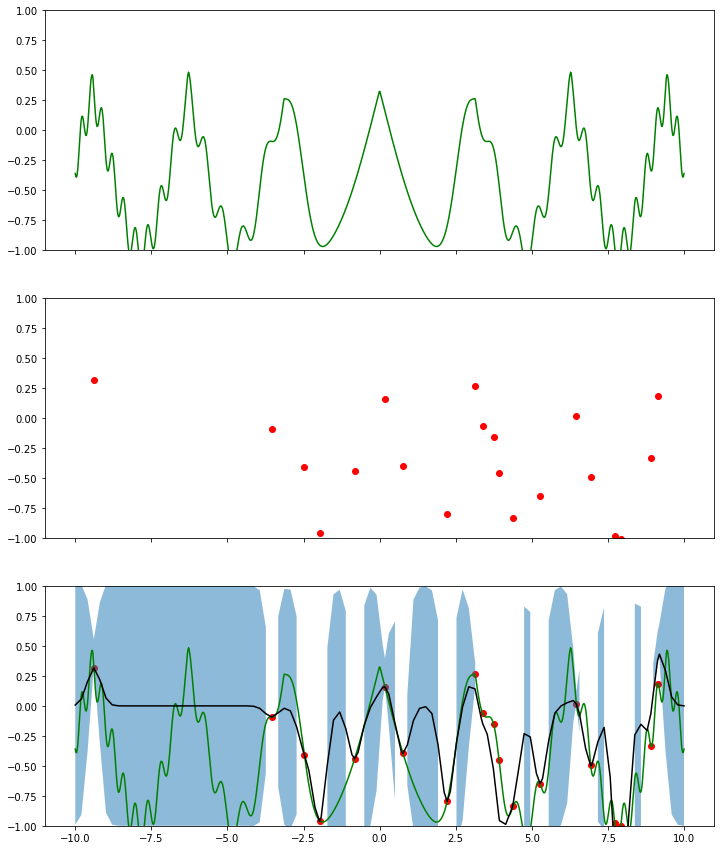

In [71]:
# Produce separate plots for clarity:
x_i = np.linspace(-10, 10,1000)
fig, axarr = plt.subplots(3, sharex = True, sharey= True, figsize=(12, 15))
axarr[0].plot(x_i, f(x_i),color='g') # The function we are trying to fit 
axarr[1].scatter(x_train, f_train,color='r') # Samples from training

axarr[2].plot(x_i, f(x_i),color='g') # The function we are trying to fit 
axarr[2].scatter(x_train, f_train,color='r') # Samples from training
axarr[2].plot(x_star, mu, color='k')
axarr[2].fill_between(x_star, np.diag(mu-var), np.sqrt(np.diag(mu+var)), alpha=0.5)
#axarr[2].plot(x_star, X[0,:], alpha=0.2)
axarr[0].set_ylim([-1, 1])